In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import matplotlib
%matplotlib inline

#### split training set and test set

In [13]:
# select 70% of dataset as training set; the remainning 30% was as test set;
# The training set and test set will be fixed in future. (only select once)
# fill na using the mean of same class samples.

def loadDataSet():
    df = pd.read_table("/home/galaxy/project/logistic_regression/new/LR_total.txt")
    matrix_list, labelMat = [], []
    for class_n in [0,1]:
        df_sub = df[df['Label'] == class_n]
        labelMat += df_sub['Label'].tolist()
        df_sub = df_sub.iloc[:, 1:]
        matrix_list.append(df_sub.fillna(df_sub.mean()))
    dataMat = pd.concat(matrix_list)
    X,Y = dataMat, labelMat
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)
    # write to file
    result_dir = "/home/galaxy/project/logistic_regression/new/"
    X_train['Label'], X_test['Label'] = Y_train, Y_test
    X_train.to_csv(os.path.join(result_dir, "Training_set.txt"), sep="\t", index=False)
    X_test.to_csv(os.path.join(result_dir, "Test_set.txt"), sep="\t", index=False)

####### Run it once!
loadDataSet()

/home/galaxy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### train model and plot roc

Training set


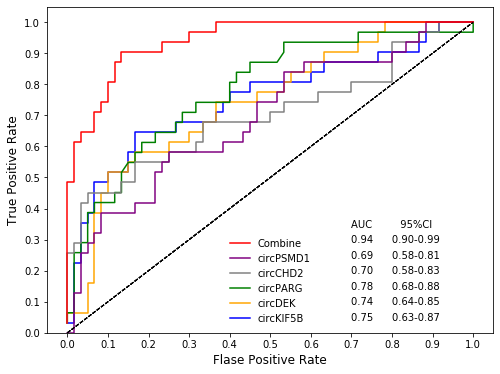

Test set


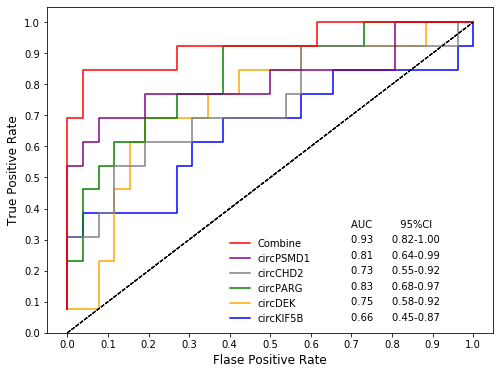

In [14]:
#### circRNA plot
# https://abdalimran.github.io/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot
def circRNA_model():
    X_train, X_test, Y_train, Y_test = load_defined_set()
    selected_circ = ['circKIF5B', 'circDEK', 'circPARG', 'circCHD2', 'circPSMD1']
    X_train_circ, X_test_circ = X_train[selected_circ], X_test[selected_circ]

    result_dir = "/home/galaxy/project/logistic_regression/new/"
    feature_num = len(selected_circ)
    feature_names = list(X_train_circ.columns)
    print("Training set")
    plot_roc(feature_num, feature_names, X_train_circ, Y_train, os.path.join(result_dir, "ROC_circRNA_train.pdf"))
    print("Test set")
    plot_roc(feature_num, feature_names, X_test_circ, Y_test, os.path.join(result_dir, "ROC_circRNA_test.pdf"))
#
circRNA_model()

Training set


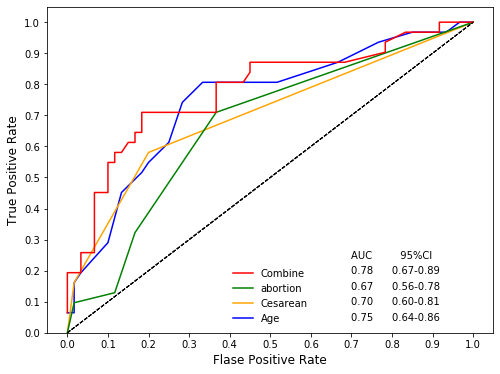

Test set


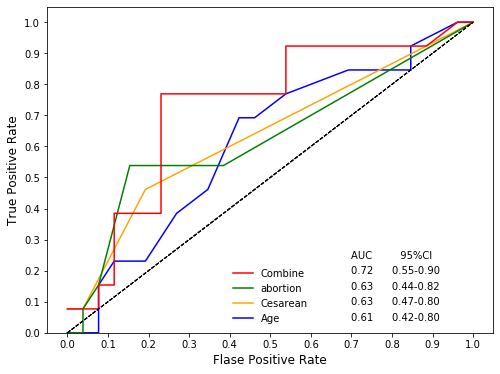

In [15]:
#### clinical plot
def clinical_model():
    X_train, X_test, Y_train, Y_test = load_defined_set()
    selected_clin = ["Age", "Cesarean", "abortion"]
    X_train_clin, X_test_clin = X_train[selected_clin], X_test[selected_clin]

    result_dir = "/home/galaxy/project/logistic_regression/new/"
    feature_num = len(selected_clin)
    feature_names = list(X_train_clin.columns)
    print("Training set")
    plot_roc(feature_num, feature_names, X_train_clin, Y_train, os.path.join(result_dir, "ROC_clinical_train.pdf"))
    print("Test set")
    plot_roc(feature_num, feature_names, X_test_clin, Y_test, os.path.join(result_dir, "ROC_clinical_test.pdf"))
    
clinical_model()

In [9]:
#### calculate circScore and clinScore
def cal_score():
    X_train, X_test, Y_train, Y_test = load_defined_set()
    def calculation(data_set, coef, intercept, feature_num):
        score_list = []
        for x in data_set:
            polynomial = 0
            for i in range(feature_num):
                polynomial += coef[i]*x[i]
            circScore = polynomial + intercept
            score_list.append(circScore)
        print(coef, intercept)
        return score_list

    #### circScore
    # selected_circ = ['circHP1BP3', 'circDEK', 'circCHD2', 'circPSMD1']
    print("calculate circScore")
    selected_circ = ['circKIF5B', 'circDEK', 'circPARG', 'circCHD2', 'circPSMD1']
    X_train_circ, X_test_circ = X_train[selected_circ], X_test[selected_circ]
    sc = StandardScaler()
    X_train_scaled = sc.fit_transform(X_train_circ)
    X_test_scaled = sc.fit_transform(X_test_circ)
    #
    classfier =LogisticRegression()
    classfier.fit(X_train_scaled, Y_train)
    coef, intercept = classfier.coef_[0], classfier.intercept_[0]
    X_train['circScore'] = calculation(X_train_scaled, coef, intercept, len(selected_circ))
    X_test['circScore'] = calculation(X_test_scaled, coef, intercept, len(selected_circ))
    X_train['Label'], X_test['Label'] = Y_train, Y_test

    #### clinical
    print("calculate clinScore")
    selected_clin = ["Age", "Cesarean", "abortion"]
    X_train_clin, X_test_clin = X_train[selected_clin], X_test[selected_clin]
    sc = StandardScaler()
    X_train_scaled = sc.fit_transform(X_train_clin)
    X_test_scaled = sc.fit_transform(X_test_clin)
    classfier = LogisticRegression()
    classfier.fit(X_train_scaled, Y_train)
    coef, intercept = classfier.coef_[0], classfier.intercept_[0]
    X_train['clinScore'] = calculation(X_train_scaled, coef, intercept, len(selected_clin))
    X_test['clinScore'] = calculation(X_test_scaled, coef, intercept, len(selected_clin))
    # print("cirScore=%fxExp(%s) + %fxExp(%s) + %fxExp(%s) + (%f)" % 
    #      (coef[0],clin_names[0],coef[1],clin_names[1],coef[2],clin_names[2],intercept))
    # coefficients = np.true_divide(classfier.coef_,  scaler.scale_)
    # print(coefficients)
    # intercept = classfier.intercept_ - np.dot(coefficients, scaler.mean_)
    # print(intercept)
    # print(X_train.head())
    # df = pd.read_table("/home/galaxy/project/logistic_regression/LR_total.txt")
    # df['cirScore'] = df['circHP1BP3']*coefficients[0][0] + df['circHNRNPK']*coefficients[0][1] + df['circAKAP9']*coefficients[0][2] + df['circ1RG']*coefficients[0][3] + intercept[0]
    result_train = "/Charles/project/logistic_regression/new/Training_circScore_clinScore.txt"
    X_train[["Label", "circScore", "clinScore", "ultrasound", "Sample"]].to_csv(result_train, sep="\t", index=False)
    result_test = "/Charles/project/logistic_regression/new/Test_circScore_clinScore.txt"
    X_test[["Label", "circScore", "clinScore", "ultrasound", "Sample"]].to_csv(result_test, sep="\t", index=False)

cal_score()

calculate circScore
[1.49980859 0.86764991 0.98539924 0.91733918 0.47789774] -0.8784101639093339
[1.49980859 0.86764991 0.98539924 0.91733918 0.47789774] -0.8784101639093339
calculate clinScore
[0.66120972 0.53526973 0.29442967] -0.7394319927069266
[0.66120972 0.53526973 0.29442967] -0.7394319927069266


#### Final ROC plot (combine circScore, clinScore and ultrasound)

Training set


/home/galaxy/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/galaxy/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/galaxy/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/galaxy/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0, flags=flags)


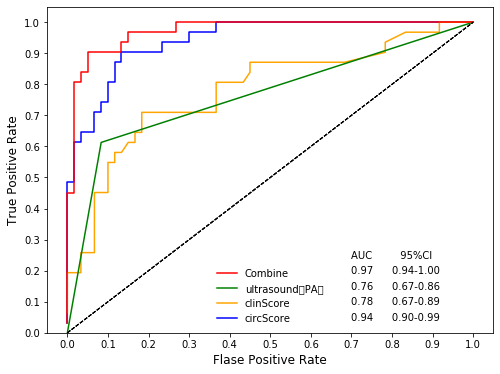

/home/galaxy/anaconda3/lib/python3.7/site-packages/matplotlib/backends/_backend_pdf_ps.py:62: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/home/galaxy/anaconda3/lib/python3.7/site-packages/matplotlib/backends/_backend_pdf_ps.py:62: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/home/galaxy/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:2001: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/galaxy/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:2001: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/galaxy/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:2099: RuntimeWarning: Glyph 65288 missing from current font.
  flags=LOAD_NO_HINTING)
/home/galaxy/anaconda3/lib/pytho

Test set


/home/galaxy/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/galaxy/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/galaxy/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/galaxy/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0, flags=flags)


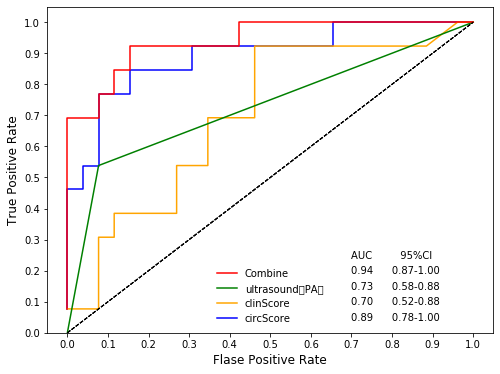

/home/galaxy/anaconda3/lib/python3.7/site-packages/matplotlib/backends/_backend_pdf_ps.py:62: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/home/galaxy/anaconda3/lib/python3.7/site-packages/matplotlib/backends/_backend_pdf_ps.py:62: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/home/galaxy/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:2001: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/galaxy/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:2001: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/galaxy/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:2099: RuntimeWarning: Glyph 65288 missing from current font.
  flags=LOAD_NO_HINTING)
/home/galaxy/anaconda3/lib/pytho

In [20]:
def final_plot():
    X_train, X_test, Y_train, Y_test = load_defined_set_score()
    selected_score = ["circScore", "clinScore", "ultrasound（PA）"]
    X_train_score, X_test_score = X_train[selected_score], X_test[selected_score]

    result_dir = "/home/galaxy/project/logistic_regression/new/"
    feature_num = len(selected_score)
    feature_names = list(X_train_score.columns)
    print("Training set")
    plot_roc(feature_num, feature_names, X_train_score, Y_train, os.path.join(result_dir, "ROC_combine_train.pdf"))
    print("Test set")
    plot_roc(feature_num, feature_names, X_test_score, Y_test, os.path.join(result_dir, "ROC_combine_test.pdf"))
final_plot()

In [11]:
### calculate Sn and Sp
def sn_and_sp():
####### final Sn and Sp
#     X_train, X_test, Y_train, Y_test = load_defined_set_score()
####### circRNA Sn and Sp
    selected_circ = ['circKIF5B', 'circDEK', 'circPARG', 'circCHD2', 'circPSMD1', 'Age', 'Cesarean', 'abortion']
    X_train, X_test, Y_train, Y_test = load_defined_set()
    X_train, X_test = X_train[selected_circ], X_test[selected_circ]
###### clinScore and ultrasound Sn and Sp
#     selected_clin = ['ultrasound（PA）', 'Age', 'Cesarean', 'abortion']
#     X_train, X_test, Y_train, Y_test = load_defined_set()
#     X_train, X_test = X_train[selected_clin], X_test[selected_clin]
##
    classfier = LogisticRegression()
    sc = StandardScaler()
    X_train_transform = sc.fit_transform(X_train)
     ###### predict whole data set
#     X, Y = pd.concat([X_train, X_test]), Y_train + Y_test
#     X_transform = sc.fit_transform(X)
#     classfier.fit(X_train_transform, Y_train)
#     Y_pred = classfier.predict(X_transform)
#     tp = len([i for i in range(len(Y)) if (Y[i] == 1) and (Y_pred[i] == 1)])
#     fn = len([i for i in range(len(Y)) if (Y[i] == 1) and (Y_pred[i] == 0)])
#     tn = len([i for i in range(len(Y)) if (Y[i] == 0) and (Y_pred[i] == 0)])
#     fp = len([i for i in range(len(Y)) if (Y[i] == 0) and (Y_pred[i] == 1)])
    ###### predict training set
    classfier.fit(X_train_transform, Y_train)
    Y_pred = classfier.predict(X_train_transform)
    tp = len([i for i in range(len(Y_train)) if (Y_train[i] == 1) and (Y_pred[i] == 1)])
    fn = len([i for i in range(len(Y_train)) if (Y_train[i] == 1) and (Y_pred[i] == 0)])
    tn = len([i for i in range(len(Y_train)) if (Y_train[i] == 0) and (Y_pred[i] == 0)])
    fp = len([i for i in range(len(Y_train)) if (Y_train[i] == 0) and (Y_pred[i] == 1)])
    ####
    print(tp, fn, tn, fp)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    print(sensitivity, specificity, accuracy)
sn_and_sp()

27 4 55 5
0.8709677419354839 0.9166666666666666 0.9010989010989011


In [84]:
### for test
# def build_onetime_modle():
#     def loadDataSet():
#         df = pd.read_table("/home/galaxy/project/logistic_regression/new/LR_total.txt")
#         selected = ['circHP1BP3', 'circDEK', 'circCHD2', 'circPSMD1'] + ["Age", "Cesarean", "Abortion"] + ['Ultrasound']
#         df_pa = df[df['Label'] == 1]
#         label_pa = df_pa['Label'].tolist()
#         df_pa = df_pa[selected]
#         df_pa = df_pa.fillna(df_pa.mean())
#         # 
#         df_con = df[df['Label'] == 0]
#         label_con = df_con['Label'].tolist()
#         df_con = df_con[selected]
#         df_con = df_con.fillna(df_con.mean())
#         dataMat = pd.concat([df_pa,df_con])
#         # print(dataMat.head())
#         labelMat = label_pa + label_con
#         return dataMat, labelMat

#     X,Y = loadDataSet()
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y) # 7:3

#     sc = StandardScaler()
#     X_train = sc.fit_transform(X_train)
#     X_test = sc.fit_transform(X_test)
#     X = sc.fit_transform(X)
#     classfier = LogisticRegression()
#     classfier.fit(X_train, Y_train)
#     ####
#     Y_pred = classfier.predict(X)
#     tp = len([i for i in range(len(Y)) if (Y[i] == 1) and (Y_pred[i] == 1)])
#     fn = len([i for i in range(len(Y)) if (Y[i] == 1) and (Y_pred[i] == 0)])
#     tn = len([i for i in range(len(Y)) if (Y[i] == 0) and (Y_pred[i] == 0)])
#     fp = len([i for i in range(len(Y)) if (Y[i] == 0) and (Y_pred[i] == 1)])
#     ####
#     # Y_pred = classfier.predict(X_train)
#     # tp = len([i for i in range(len(Y_train)) if (Y_train[i] == 1) and (Y_pred[i] == 1)])
#     # fn = len([i for i in range(len(Y_train)) if (Y_train[i] == 1) and (Y_pred[i] == 0)])
#     # tn = len([i for i in range(len(Y_train)) if (Y_train[i] == 0) and (Y_pred[i] == 0)])
#     # fp = len([i for i in range(len(Y_train)) if (Y_train[i] == 0) and (Y_pred[i] == 1)])
#     ####
#     print(tp, fn, tn, fp)
#     sensitivity = tp / (tp + fn)
#     specificity = tn / (tn + fp)
#     accuracy = (tp+tn)/(tp+fn+fp+tn)
#     print(sensitivity, specificity, accuracy)
    
# build_onetime_modle()

34 10 80 10
0.7727272727272727 0.8888888888888888 0.8507462686567164


#### defined function (need to run first)!

In [2]:
def load_defined_set():
    train = "/Charles/project/logistic_regression/new/Training_set.txt"
    test = "/Charles/project/logistic_regression/new/Test_set.txt"
    
    def read_file(in_file):
        df = pd.read_table(in_file, sep="\t")
        return df.iloc[:, :-1], df['Label'].tolist()
    
    X_train, Y_train = read_file(train)
    X_test, Y_test = read_file(test)
    return X_train, X_test, Y_train, Y_test

def load_defined_set_score():
    train = "/Charles/project/logistic_regression/new/Training_circScore_clinScore.txt"
    test = "/Charles/project/logistic_regression/new/Test_circScore_clinScore.txt"
    
    def read_file(in_file):
        df = pd.read_table(in_file, sep="\t")
        return df[["circScore","clinScore","ultrasound（PA）"]], df['Label'].tolist()
    
    X_train, Y_train = read_file(train)
    X_test, Y_test = read_file(test)
    return X_train, X_test, Y_train, Y_test

In [3]:
def plot_roc(feature_num, feature_names, X_data, Y_data, result_file):
    color_db = ['blue','orange','green','grey','purple','olive','sienna','pink','cyan','magenta','yellow']
    height_db = [0.04,0.09,0.14,0.19,0.24,0.29,0.34,0.39,0.45,0.49,0.54]
    f,ax = plt.subplots(figsize=(8,6))
    color_list = color_db[:feature_num] + ['red']
    height_list = height_db[:(feature_num+1)]
    legend_list = feature_names + ["Combine"]
    set_list = [X_data[x] for x in feature_names] + [X_data]
    for i in range(len(set_list)):
        if i != feature_num:
            i_set = [[x] for x in set_list[i]]
        else:
            i_set = set_list[i]
        classfier = LogisticRegression()
        sc = StandardScaler()
        i_set = sc.fit_transform(i_set)
        classfier.fit(i_set, Y_data)
        y_score = classfier.predict_proba(i_set)[:,1]
        fpr,tpr,threshold = metrics.roc_curve(Y_data, y_score)
        roc_auc = metrics.auc(fpr,tpr)
        plt.stackplot(fpr, tpr, color='white', alpha = 0.5, edgecolor = 'black')
        plt.plot(fpr, tpr, color=color_list[i], lw = 1.5, label=legend_list[i])
        plt.plot([0,1],[0,1], color = 'black', linestyle = '--', lw = 1)
        plt.xticks(np.arange(0.0, 1.1, step=0.1))
        plt.xlabel("Flase Positive Rate", fontsize=12)
        plt.yticks(np.arange(0.0, 1.1, step=0.1))
        plt.ylabel("True Positive Rate", fontsize=12)
        ci = calculate_ci(Y_data, y_score)
        plt.text(0.7,height_list[i],'%0.2f      %0.2f-%0.2f' % (roc_auc, ci[0], ci[1]), fontsize=10)
        plt.legend(loc='lower center', fontsize=10, frameon=False)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='lower center', fontsize=10, frameon=False)
    plt.text(0.7,(height_list[-1]+0.05),'AUC         95%CI', fontsize=10)
    plt.show()
    f.savefig(result_file, bbox_inches='tight')

In [4]:
def calculate_ci(Y_train, y_score):
    alpha = .95
    auc, auc_cov = delong_roc_variance(Y_train, y_score)
    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)
    ci = stats.norm.ppf(lower_upper_q, loc=auc, scale=auc_std)
    ci[ci > 1] = 1
    # print('AUC:', auc)
    # print('AUC COV:', auc_cov)
    # print('95% AUC CI:', ci)
    return ci

In [5]:
import numpy as np
import scipy.stats
from scipy import stats

def compute_midrank(x):
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    # order = (-ground_truth).argsort()
    order = np.negative(ground_truth).argsort()
    # label_1_count = int(ground_truth.sum())
    label_1_count = int(sum(ground_truth))
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]
    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov